In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [2]:
ENCRYPTED_DIRECTORY = "data/govdocs_encrypted"
PLAINTEXT_DIRECTORY = "data/govdocs_plaintext"

In [3]:
def load_data(directory):
    dataframes = list()
    for f in glob.glob(f"{directory}/**.csv.gz"):
        df = pd.read_csv(f)
        dataframes.append(df)
    return pd.concat(dataframes)

df_plaintext = load_data(PLAINTEXT_DIRECTORY)
df_plaintext["is_encrypted"] = 0
df_encrypted = load_data(ENCRYPTED_DIRECTORY)
df_encrypted["is_encrypted"] = 1

master_df = pd.concat([df_plaintext, df_encrypted])

# Filter out only webp
# master_df = master_df[master_df['extended.extension'] != '.webp']
print("only webp: ", master_df.shape)

# Filter out files which are larger than 4k
#master_df = master_df[master_df['baseline.filesize'] > 4096]
print("greater than 4096: ", master_df.shape)

# Shuffle
master_df = master_df.sample(frac=1).reset_index(drop=True)

# fill Nan with 0
master_df['baseline.chisquare_end'] = master_df['baseline.chisquare_end'].fillna(0.0)
master_df.dropna(inplace=True)


/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_25304/2908337352.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plaintext["is_encrypted"] = 0
/var/folders/z1/hfz3q2b52bx3hb8nh0z1q89c0000gp/T/ipykernel_25304/2908337352.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encrypted["is_encrypted"] = 1


only webp:  (160507, 528)
greater than 4096:  (160507, 528)


In [9]:
#columns_to_consider = [c for c in master_df.columns]
#columns_to_consider = [c for c in master_df.columns if c.startswith("baseline")]
#columns_to_consider.append('is_encrypted')
columns_to_consider = [c for c in master_df.columns if c != 'extended.extension']


interesting_df = master_df[columns_to_consider]

X = interesting_df[[c for c in interesting_df.columns if c.startswith('baseline')]]
X = interesting_df[[c for c in interesting_df.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if c != 'is_encrypted']]
X = X[[c for c in X.columns if "size" not in c.lower()]]

# get rid of tail and head metrics
#X = X[[c for c in X.columns if "begin" not in c and "head" not in c]]
#X = X[[c for c in X.columns if "tail" not in c and "end" not in c]]

#X = X[[c for c in X.columns if "kurtosis" not in c and "skew" not in c]]
#X = X[[c for c in X.columns if "fourier" not in c.lower()]]

y = interesting_df['is_encrypted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print(X_train.columns)

Index(['baseline.head_shannon_entropy', 'baseline.tail_shannon_entropy',
       'baseline.shannon_entropy', 'baseline.montecarlo_pi',
       'baseline.chisquare_full', 'baseline.chisquare_begin',
       'baseline.chisquare_end', 'baseline.autocorrelation_full',
       'baseline.autocorrelation_begin', 'baseline.autocorrelation_end',
       'baseline.filesize'],
      dtype='object')


In [5]:
rfc = RandomForestClassifier(n_jobs=-1)
estimators = [('std,', MinMaxScaler()), ('LogisticRegressor', LogisticRegression())]
estimators = [('std,', MinMaxScaler()), ('RFC', rfc)]
pipeline = Pipeline(estimators)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
print(precision, recall, fscore, support)
print(f"F1 = {f1_score(y_test, y_pred)}")

[0.74824356 0.75      ] [0.75970938 0.73823052] [0.75393288 0.74406872] [7570 7392]
F1 = 0.7440687210253613


In [ ]:
print(X_train.columns)

Index(['Unnamed: 0', 'baseline.shannon_entropy', 'baseline.montecarlo_pi',
       'baseline.chisquare_full', 'baseline.autocorrelation_full',
       'fourier.stat.1byte.autocorr', 'fourier.stat.1byte.mean',
       'fourier.stat.1byte.std', 'fourier.value.1byte.0',
       'fourier.value.1byte.1',
       ...
       'fourier.value.4byte.241', 'fourier.value.4byte.242',
       'fourier.value.4byte.243', 'fourier.value.4byte.244',
       'fourier.value.4byte.245', 'fourier.value.4byte.246',
       'fourier.value.4byte.247', 'fourier.value.4byte.248',
       'fourier.value.4byte.249', 'fourier.value.4byte.250'],
      dtype='object', length=513)


<BarContainer object of 11 artists>

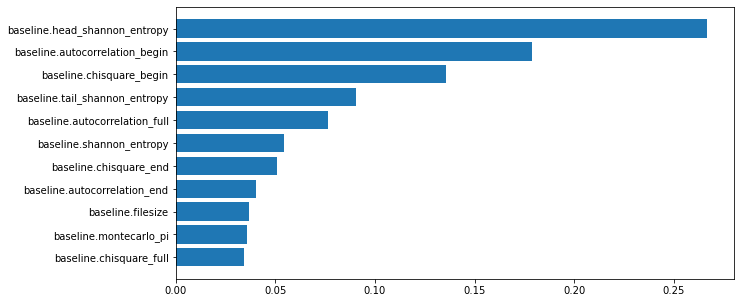

In [21]:
plt.rcParams["figure.figsize"] = (10,5)

columns = np.array([c for c in X_train.columns])
sort_array = np.argsort(rfc.feature_importances_)
      
plt.barh(X_train.columns[sort_array], rfc.feature_importances_[sort_array])
